# Synthetic Data Quality Evaluation: Feature Space Analysis

In [1]:
# import libraries
import os
os.chdir("..")
import torch
import pandas as pd
import numpy as np
import PIL
from PIL import Image
from torchvision.utils import make_grid
from torchvision import transforms
from matplotlib import pyplot as plt
from utils.data_utils import ImageDataset
import seaborn as sns
from tqdm import tqdm

## Load Data

In [181]:
real_dataset_path = "/home/zchayav/projects/syntheye/euclidean_results/real_wo_repeats.csv"
synthetic_dataset_path = "/home/zchayav/projects/syntheye/euclidean_results/synth.csv"

# add image transforms
tr = transforms.Compose([transforms.Resize((512, 512)), transforms.Grayscale(3), transforms.ToTensor(), transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))])

# load csvs
real_dataset = ImageDataset(real_dataset_path, "file.path", "gene", class_vals="classes.txt", transforms=tr, class_mapping="classes_mapping.json")
synthetic_dataset = ImageDataset(synthetic_dataset_path, "file.path", "gene", class_vals="classes.txt", transforms=tr, class_mapping="classes_mapping.json")
synth_dataloader = torch.utils.data.DataLoader(synthetic_dataset, batch_size=128)
real_dataloader = torch.utils.data.DataLoader(real_dataset, batch_size=128)

In [182]:
len(real_dataset), len(synthetic_dataset)

(6087, 6087)

## Feature Space Analysis

### Inception Feature Extractor

In [184]:
# load inceptionv3 trained on real data
from torchvision.models import inception_v3
model_weights = torch.load("/home/zchayav/projects/syntheye/classifier_training/experiments/feature_extractor/best_weights.pth", map_location='cpu')

# load architecture
model = inception_v3(pretrained=True)
model.AuxLogits.fc = torch.nn.Linear(768, 36)
model.fc = torch.nn.Linear(2048, 36)
# load weights
model.load_state_dict(model_weights)
# replace last layer with identity layer
model.fc = torch.nn.Identity()
# add on GPU
model.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [185]:
# get feature maps of all images
real_features = []
for _, _, x, y in tqdm(real_dataloader):
    model.eval()
    real_features.append(model(x).detach().cpu().numpy())

100%|██████████| 48/48 [07:21<00:00,  9.20s/it]


In [186]:
# get feature maps of all images
synthetic_features = []
for _, _, x, y in tqdm(synth_dataloader):
    model.eval()
    synthetic_features.append(model(x).detach().cpu().numpy())

100%|██████████| 48/48 [06:08<00:00,  7.68s/it]


In [187]:
real_features = np.concatenate(real_features, axis=0)
synthetic_features = np.concatenate(synthetic_features, axis=0)

### Other feature extractors

In [ ]:
# # compress images into 1024 dim space using autoencoder
# from image_encoder.ae_model import ConvolutionalAE

# weights = torch.load("/home/zchayav/projects/syntheye/image_encoder/experiment_7/best_weights.pth")

# autoencoder = ConvolutionalAE(im_size=512, latent_size=2048)
# autoencoder.load_state_dict(weights)

In [ ]:
# autoencoder.eval()
# autoencoder.to("cuda:0")

# # get feature maps of all images
# real_features = []
# synthetic_features = []

# for _, _, x, y in tqdm(real_dataloader):
#     real_features.append(autoencoder.encoder(x.to("cuda:0")).detach().cpu().numpy())

# for _, _, x, y in tqdm(synth_dataloader):
#     synthetic_features.append(autoencoder.encoder(x.to("cuda:0")).detach().cpu().numpy())

# autoencoder.to("cpu")

# real_features = np.concatenate(real_features, axis=0)
# synthetic_features = np.concatenate(synthetic_features, axis=0)

In [ ]:
# real_features.shape, synthetic_features.shape

In [ ]:
# x_reconstructed = (autoencoder(x).detach().cpu().numpy() + 1) / 2
# x_original = (x.detach().cpu().numpy() + 1) / 2
    
# for i in range(50):
#     plt.figure()
#     plt.subplot(1, 2, 1)
#     plt.imshow(x_original[i].squeeze(), plt.cm.gray)
#     plt.subplot(1, 2, 2)
#     plt.imshow(x_reconstructed[i].squeeze(), plt.cm.gray)
#     plt.show()

## Compute UMAP Embeddings

In [188]:
# embed the real dataset in 2D
def run_dim_reduce(data, n_neighbors, min_dist, n_components=2, transform=False, random_state=1399):

    import umap
    
    mapper = umap.UMAP(n_neighbors=n_neighbors, min_dist=min_dist, random_state=random_state, n_components=n_components)
    mapper.fit(data)

    if transform:
        embeddings = mapper.transform(np.float32(data))
        return (mapper, embeddings)
    else:
        return mapper

In [189]:
# concatenate real and synthetic features 
all_features = np.concatenate([real_features, synthetic_features], axis=0)

# set hyperparameters
n_neighbors = [20] #[10, 20, 50, 100, 200]
min_dist = [0.99] #[0, 0.1, 0.5, 0.99]

# run 2d dimensionality reduction algorithm
embeddings = np.zeros((len(n_neighbors), len(min_dist), len(all_features), 2))
for i, n in enumerate(n_neighbors):
    for j, m in enumerate(min_dist):
        print("Nearest Neighbors = {}, Min Dist = {}".format(n, m))
        mapper, embed = run_dim_reduce(all_features, n_neighbors=n, min_dist=m, n_components=2, transform=True, random_state=1399)
        embeddings[i, j, :, :] = embed
        print("\n")

Nearest Neighbors = 20, Min Dist = 0.99




## Show plots per class

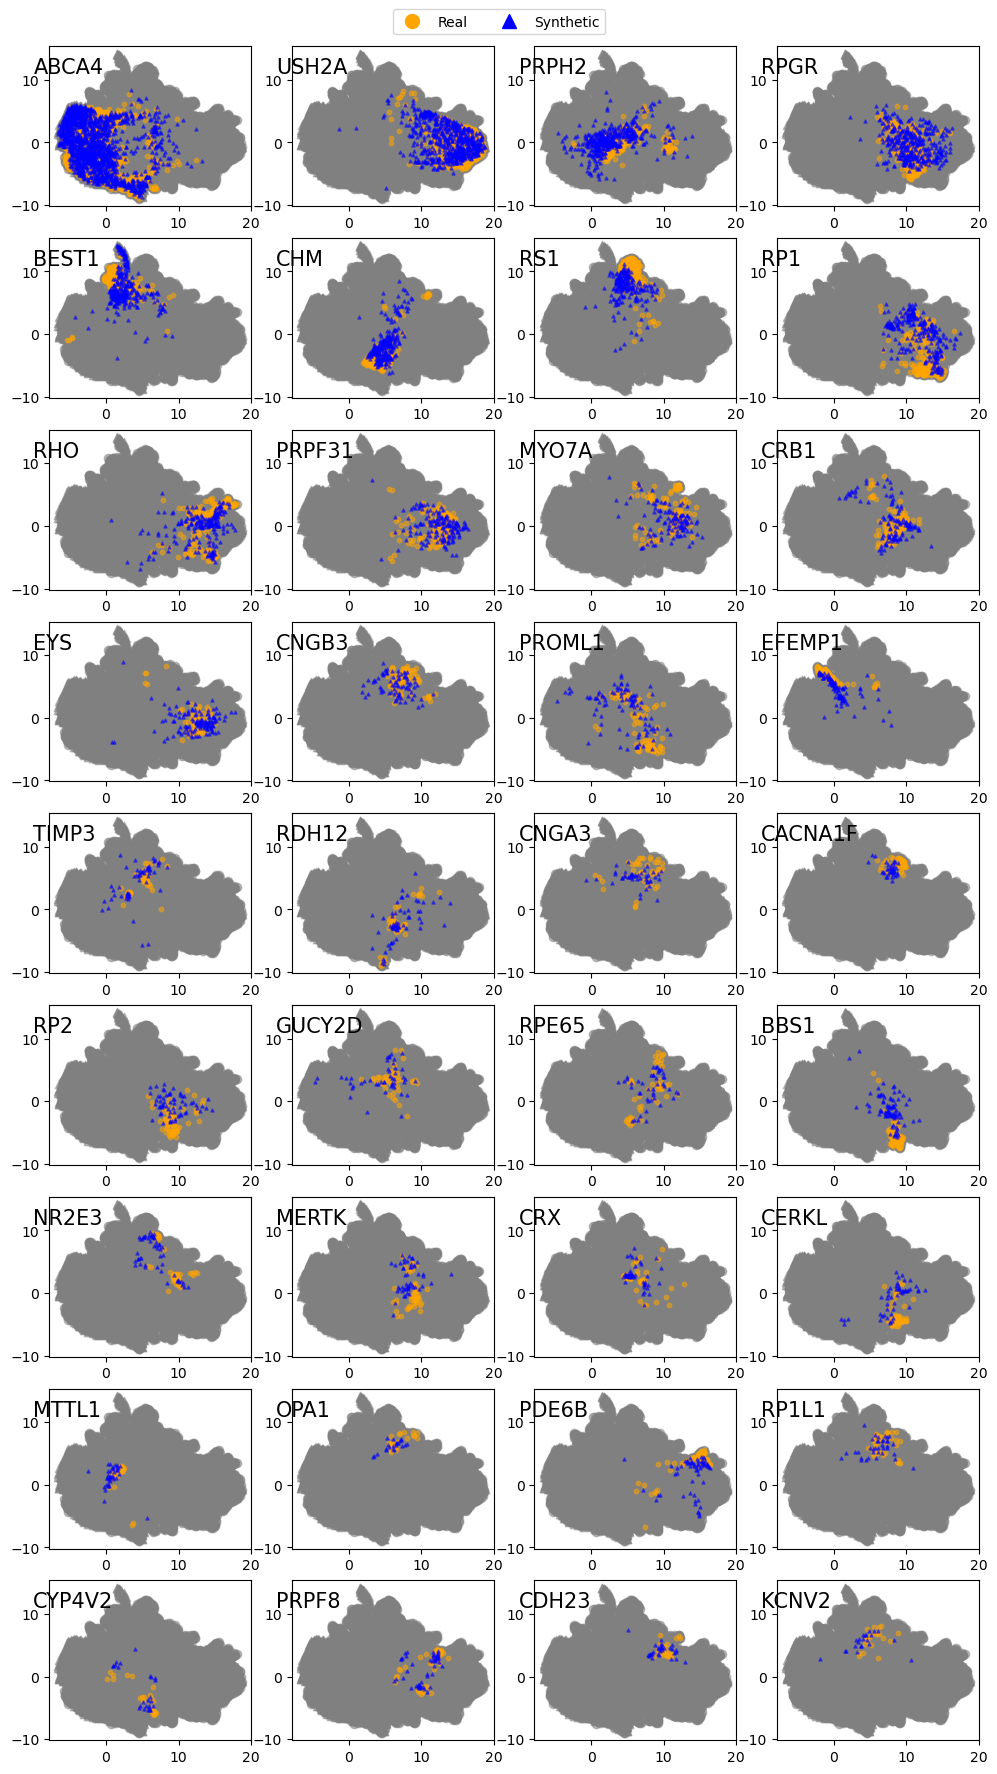

In [190]:
n = 20
m = 0.99

i = n_neighbors.index(n)
j = min_dist.index(m)

# grab embeddings
embed = embeddings[i, j]

# separate into real vs synthetic
real_embeddings, synthetic_embeddings = embed[:len(real_features)], embed[len(real_features):]

real_labels = np.array([real_dataset.class2idx[i] for i in real_dataset.img_labels])
synthetic_labels = np.array([synthetic_dataset.class2idx[i] for i in synthetic_dataset.img_labels])

with open("classes.txt") as f:
    target_names = f.read().splitlines()

target_ids = list(real_dataset.class2idx[name] for name in target_names)

l = 1
plt.figure(figsize=(12, 22))
for k, label in zip(target_ids, target_names):
    
    # plot the full manifold
    plt.subplot(9, 4, l)
#     plt.title("Gene: {}".format(label), y=1.08)
    plt.text(-10, 11, label, fontsize=15)
    plt.scatter(real_embeddings[:, 0], real_embeddings[:, 1], c="grey", marker="o", alpha=0.5)
    plt.scatter(synthetic_embeddings[:, 0], synthetic_embeddings[:, 1], c="grey", marker="^", alpha=0.5)
    
    # plot just highlighted gene region on manifold
    plt.scatter(real_embeddings[real_labels == k, 0], real_embeddings[real_labels == k, 1], c="orange", marker="o", alpha=0.5, s=10)
    plt.scatter(synthetic_embeddings[synthetic_labels == k, 0], synthetic_embeddings[synthetic_labels == k, 1], c="blue", marker="^", alpha=0.5, s=5)
    l += 1
    
import matplotlib.lines as mlines
orange_circle = mlines.Line2D([], [], color="orange", marker="o", linestyle="None", markersize=10, label="Real")
blue_triangle = mlines.Line2D([], [], color="blue", marker="^", linestyle="None", markersize=10, label="Synthetic")
plt.figlegend(handles=[orange_circle, blue_triangle], ncol=2, loc="upper center", bbox_to_anchor=(0.5, 0.9))

# plt.suptitle("Real vs Synthetic Image Visualizations in Lower Dimensional Space", bbox_to_anchor=(0.5, 1))
plt.show()
plt.tight_layout()
plt.close()

In [ ]:
# # graph_per_class = False

# # for i, n in enumerate(n_neighbors):
# #     for j, m in enumerate(min_dist):

# #         # grab embeddings
# #         embed = embeddings[i, j]

# #         # separate into real vs synthetic
# #         real_embeddings, synthetic_embeddings = embed[:len(real_features)], embed[len(real_features):]
        
# #         real_labels = np.array([real_dataset.class2idx[i] for i in real_dataset.img_labels])
# #         synthetic_labels = np.array([synthetic_dataset.class2idx[i] for i in synthetic_dataset.img_labels])
# #         target_names = list(real_dataset.class2idx.keys())
# #         target_ids = list(real_dataset.class2idx.values())
# #         assert len(target_names) == len(target_ids)
# #         assert real_embeddings.shape[0] == len(real_labels)
# #         assert synthetic_embeddings.shape[0] == len(synthetic_labels)

# #         plt.figure(figsize=(9,6))
# #         plt.title("N = {}, M = {}".format(n, m))
# #         if graph_per_class:
# #             for k, label in zip(target_ids, target_names):
# #                 plt.scatter(real_embeddings[real_labels == k, 0], real_embeddings[real_labels == k, 1], label=label, marker="o", alpha=0.5)
# #                 plt.scatter(synthetic_embeddings[synthetic_labels == k, 0], synthetic_embeddings[synthetic_labels == k, 1], label=label, marker="^", alpha=0.3)
# #         else:
# #             plt.scatter(real_embeddings[:, 0], real_embeddings[:, 1], c="red", marker="o", alpha=0.5)
# #             plt.scatter(synthetic_embeddings[:, 0], synthetic_embeddings[:, 1], c="blue", marker="^", alpha=0.5)
# #         plt.legend(["Real", "Synthetic"], loc='upper right')
# #         plt.show()
# #         plt.close()

# def plot_umap(nrows, ncols, embeddings1, embeddings2, labels1, labels2, labels, title):
#     assert nrows*ncols >= len(labels)
    
#     # create figure
#     fig, axs = plt.subplots(nrows=nrows, ncols=ncols, squeeze=False, figsize=(3*ncols, 3*nrows))
    
#     for i, cls in enumerate(labels):
        
#         r = i // ncols
#         c = i % ncols
        
#         # plot all features
#         axes[r,c].scatter(embeddings1[:, 0], embeddings1[:, 1], c="grey", marker="o", alpha=0.5)
#         axes[r,c].scatter(embeddings2[:, 0], embeddings2[:, 1], c="grey", marker="^", alpha=0.5)
#         # plot gene subset features
#         axes[r,c].scatter(embeddings1[labels1 == k, 0], embeddings1[labels1 == k, 1], c="orange", marker="o", alpha=0.5, s=10)
#         axes[r,c].scatter(embeddings2[labels2 == k, 0], embeddings2[labels2 == k, 1], c="blue", marker="^", alpha=0.5, s=5)
        
#     fig.subplots_adjust(wspace=0.05)
#     fig.suptitle(title, fontsize=16, y=1)
    
#     plt.tight_layout()
#     plt.show()
#     plt.close()
    
# n = 20
# m = 0.99

# i = n_neighbors.index(n)
# j = min_dist.index(m)

# # grab embeddings
# embed = embeddings[i, j]

# # separate into real vs synthetic
# real_embeddings, synthetic_embeddings = embed[:len(real_features)], embed[len(real_features):]

# real_labels = np.array([real_dataset.class2idx[i] for i in real_dataset.img_labels])
# synthetic_labels = np.array([synthetic_dataset.class2idx[i] for i in synthetic_dataset.img_labels])
# with open("classes.txt") as f:
#     target_names = f.read().splitlines()

# target_ids = list(real_dataset.class2idx[name] for name in target_names)

In [35]:
distmats = os.listdir('quantitative_results/stylegan2_results/real_vs_synthetic_euclidean/')
distmats = [os.path.join('quantitative_results/stylegan2_results/real_vs_synthetic_euclidean/', f) for f in distmats if f.endswith('.csv') and f != 'summary.csv']

In [36]:
# most_similar = pd.DataFrame(columns=[])
euclidean = []
for f in distmats:
    df = pd.read_csv(f).iloc[0]
    euclidean.append(df['euclidean'])

In [38]:
np.mean(euclidean)

10.639623986111111